In [12]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [13]:
# Create Spark session
spark = SparkSession.builder.appName("StockPrediction").getOrCreate()

In [14]:
# Define the schema
schema = "date STRING, open DOUBLE, high DOUBLE, low DOUBLE, close DOUBLE, volume INT, Name STRING"

In [15]:
# Load the dataset into a Spark DataFrame with the specified schema
df = spark.read.csv("/content/drive/MyDrive/Self-Learning-Projects/Stocks_Prediction/data/all_stocks_5yr.csv", header=True, schema=schema)

In [16]:
# Data Cleaning and Transformations
df = df.dropna()  # Drop rows with null values
df = df.withColumn("date", to_date(col("date"), "yyyy-MM-dd"))  # Convert date column to DateType

In [17]:
# Splitting the Data
(train_data, test_data) = df.randomSplit([0.8, 0.2], seed=42)

In [18]:
# Feature Engineering
assembler = VectorAssembler(inputCols=["open", "high", "low", "volume"], outputCol="features")
train_data = assembler.transform(train_data)
test_data = assembler.transform(test_data)

In [19]:
# Model Training
lr = LinearRegression(labelCol="close", featuresCol="features")
model = lr.fit(train_data)

In [22]:
# Model Evaluation
predictions = model.transform(test_data)
evaluator = RegressionEvaluator(labelCol="close", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 0.7012637319846948


# **Visualizations**

*Plot* historical data of top 5 stocks

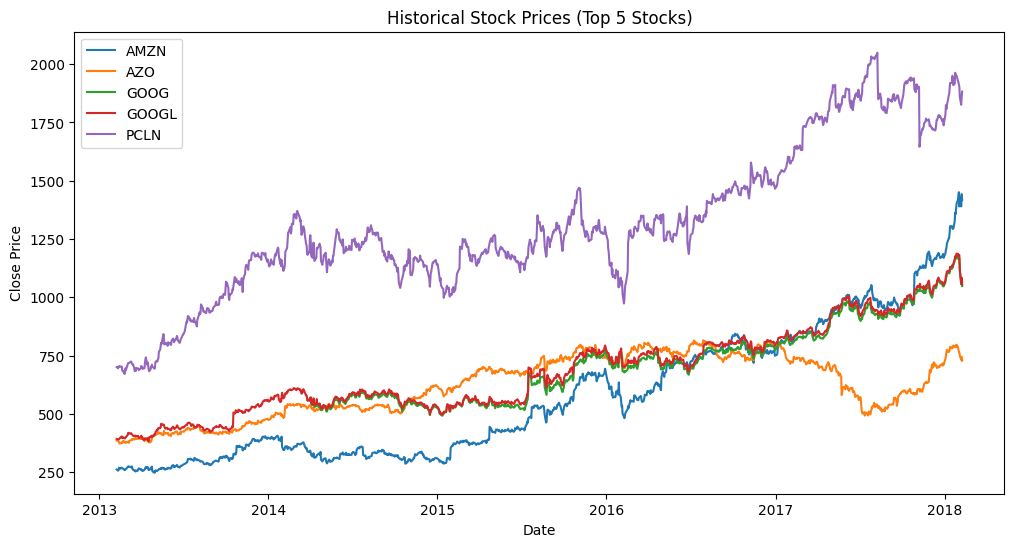

In [25]:
# Historical Stock Prices
df_pd = df.toPandas()

# Calculate the top 5 stocks based on mean closing price
top_stocks = df_pd.groupby("Name")["close"].mean().nlargest(5).index

plt.figure(figsize=(12, 6))
for name, group in df_pd.groupby("Name"):
    if name in top_stocks:
        plt.plot(group["date"], group["close"], label=name)

plt.title("Historical Stock Prices (Top 5 Stocks)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()

<ipython-input-27-c13ef776ac94>:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(pivot_df_pd.corr(), annot=True, cmap="coolwarm")


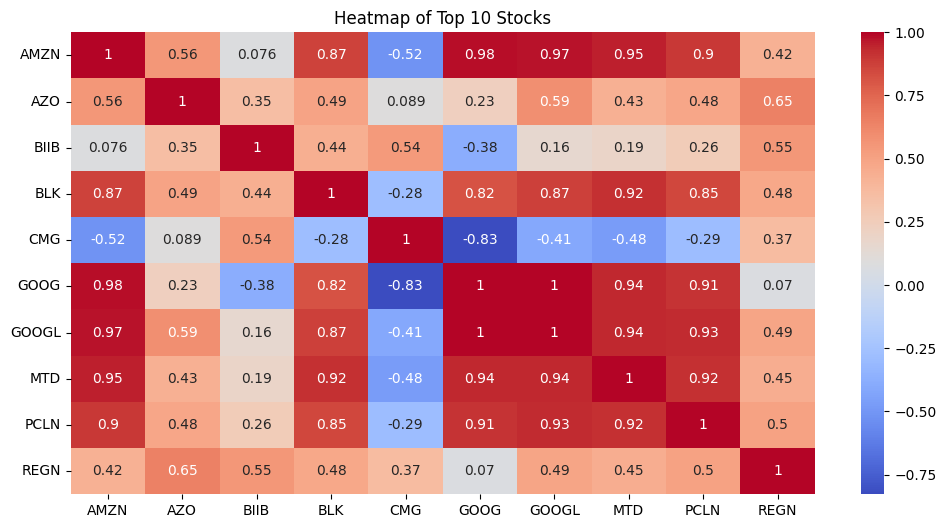

In [27]:
# Heatmap of Top 10 Stocks
top_stocks = df.groupBy("Name").agg(mean("close")).orderBy(desc("avg(close)")).limit(10).select("Name").rdd.flatMap(lambda x: x).collect()

pivot_df = df.filter(col("Name").isin(top_stocks)).groupBy("date").pivot("Name").agg(first("close")).orderBy("date")
pivot_df_pd = pivot_df.toPandas()

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_df_pd.corr(), annot=True, cmap="coolwarm")
plt.title("Heatmap of Top 10 Stocks")
plt.show()


Text(0, 0.5, 'Close Price')

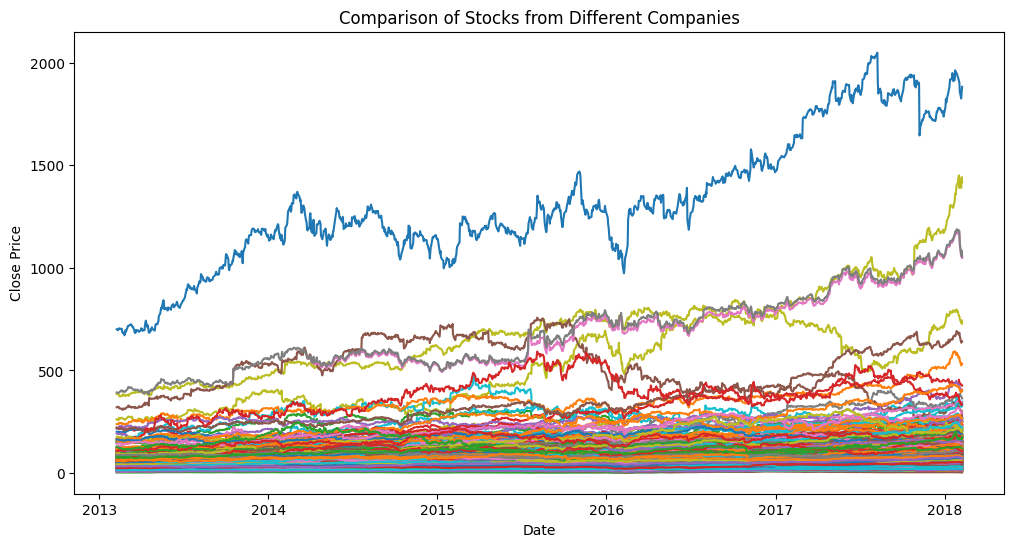

In [28]:
# Comparison of Stocks from Different Companies
plt.figure(figsize=(12, 6))
for name, group in df_pd.groupby("Name"):
    plt.plot(group["date"], group["close"], label=name)
plt.title("Comparison of Stocks from Different Companies")
plt.xlabel("Date")
plt.ylabel("Close Price")

<ipython-input-29-f5d50582eae8>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  average_close = df_pd.groupby("date").mean()["close"]


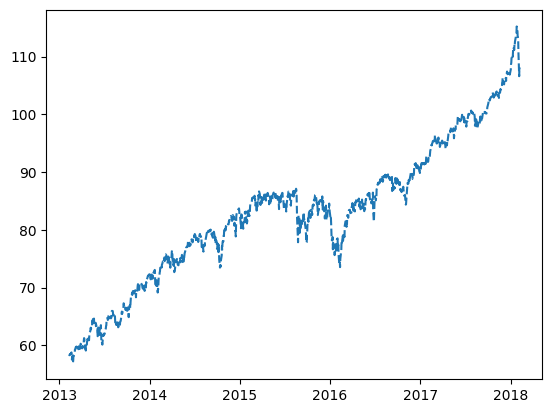

In [29]:
# Average of All Stocks
average_close = df_pd.groupby("date").mean()["close"]
plt.plot(average_close.index, average_close.values, label="Average", linestyle='--')

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


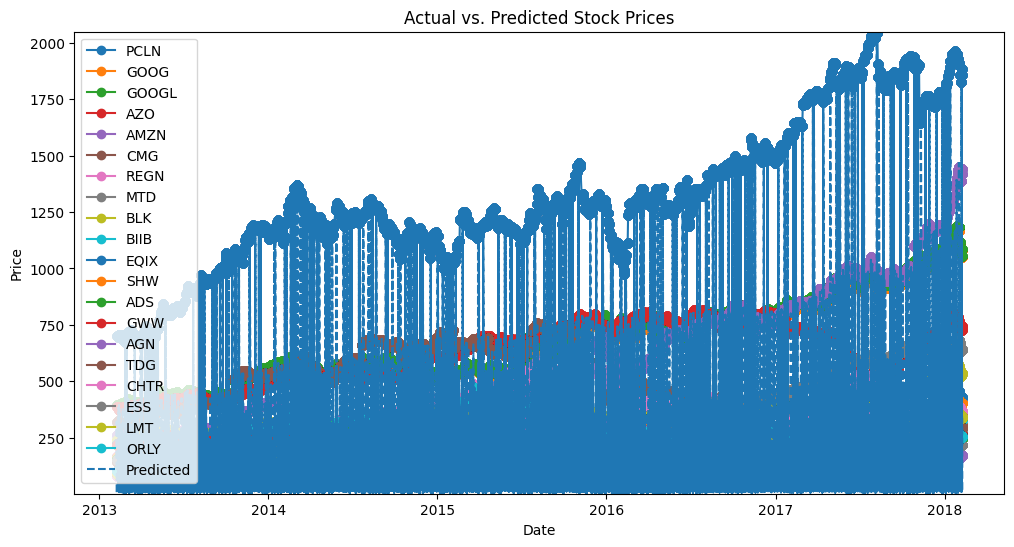

In [56]:
import matplotlib.pyplot as plt

# Retrieve the actual and predicted prices for the top 20 stocks
top_stocks = df.groupBy("Name").agg(mean("close")).orderBy(desc("avg(close)")).limit(20).select("Name").rdd.flatMap(lambda x: x).collect()
actual_prices = df.filter(col("Name").isin(top_stocks)).select("date", "close", "Name").toPandas()

predictions_pd = predictions.select("date", "prediction").toPandas()

# Merge actual and predicted prices
merged_df = actual_prices.merge(predictions_pd, on="date", how="inner")

# Set the figure size
plt.figure(figsize=(12, 6))

# Plotting the actual stock prices
for name in top_stocks:
    stock_data = merged_df[merged_df["Name"] == name]
    plt.plot(stock_data["date"], stock_data["close"], label=name, linestyle="-", marker="o")

# Plotting the predicted stock prices
plt.plot(merged_df["date"], merged_df["prediction"], label="Predicted", linestyle="--")

# Set y-axis limits to accommodate both actual and predicted prices
y_min = merged_df[["close", "prediction"]].values.min()
y_max = merged_df[["close", "prediction"]].values.max()
plt.ylim(y_min - 1, y_max + 1)

# Set the plot title and labels
plt.title("Actual vs. Predicted Stock Prices")
plt.xlabel("Date")
plt.ylabel("Price")

# Display the legend
plt.legend()

# Show the plot
plt.show()


In [ ]:
# Close Spark session
spark.stop()